In [108]:
import pandas as pd
import statsmodels.api as sm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')

# Modeling Incidence

In this notebook we present modeling of  two metrics of cancer incidence number of tumors located **insitu** per 1000 of totally diagnozed tumors (insitu means that abnormal cells have been found in their place of origin but have not spread to nearby tissues). And number of diagnozed **multiple tumors** per 1000 cases

The following model must reflect ongoing reforms in Ukrainian medical system as well as COVID19 outbreak and full-scale invasion in 2022

In [109]:
st_df = pd.read_csv('./final_dataset/stage_incidence_features.csv')

In [110]:
st_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      336 non-null    int64  
 1   region                    336 non-null    object 
 2   mtumors                   336 non-null    float64
 3   syncmtumors               336 non-null    float64
 4   insitu                    336 non-null    float64
 5   ncervix                   336 non-null    float64
 6   nhospotal_pht             336 non-null    float64
 7   nbeds_pht                 336 non-null    float64
 8   ybeds_pht                 336 non-null    float64
 9   nill_pht                  336 non-null    float64
 10  nvillage_ill_pht          336 non-null    float64
 11  bed_days_pht              336 non-null    float64
 12  dvisits_pht               336 non-null    float64
 13  hvisits_pht               336 non-null    float64
 14  ndoctors_p

In [111]:
st_df = st_df.drop(columns=['tincidence_pht', 'mtumors', 'syncmtumors', 'insitu', 'ncervix', 'nvillage_ill_pht',
                            'hvisits_pht', 'ndialysis_pht', 'ndialysis_pht', 'nbacter_pht', 
                            'dumps_not_cleaned_enough', 'nphysic_pht'])


In [112]:
st_df.columns

Index(['year', 'region', 'nhospotal_pht', 'nbeds_pht', 'ybeds_pht', 'nill_pht',
       'bed_days_pht', 'dvisits_pht', 'ndoctors_pht', 'nnursing_pht',
       'nx_ray_pht', 'nflurography_pht', 'nradiology_pht', 'nradlab_pht',
       'nсt_pht', 'ncardiogram_pht', 'ndiaglab_pht', 'nbiochem_pht',
       'ncyto_pht', 'nimun_pht', 'nendoscop_pht', 'nultrasound_pht',
       'air_pollution', 'polluted_dumps', 'not_cleaned_dumps',
       'num_clearing_plants', 'cpi', 'population', 'mtumors_pht',
       'syncmtumors_pht', 'insitu_pht', 'insitu_pti', 'mtumors_pti', 'gdp',
       'aging_level', 'mean_age'],
      dtype='object')

## EDA

### Feature Selection

Let first sort all variables into several groups

1. **Equipment**
2. **Medical Personnel**
3. **Illness**
4. **Socioeconomic**

In [113]:

equipment_variables = [
    'nx_ray_pht', 'nflurography_pht', 'nradiology_pht',
    'nсt_pht', 'ndiaglab_pht', 'nendoscop_pht', 'nultrasound_pht',
]

personnel_variables = ['ndoctors_pht', 'nnursing_pht']

environment_variables = ['air_pollution']

illness_variables = ['nill_pht', 'dvisits_pht']

socioeconomic_variables = ["gdp", "mean_age"]

all_explanatory_variables = equipment_variables + personnel_variables + illness_variables + socioeconomic_variables + environment_variables

all_dependent_variables = ['mtumors_pti']

Then, let check correlation table among explanatory variables

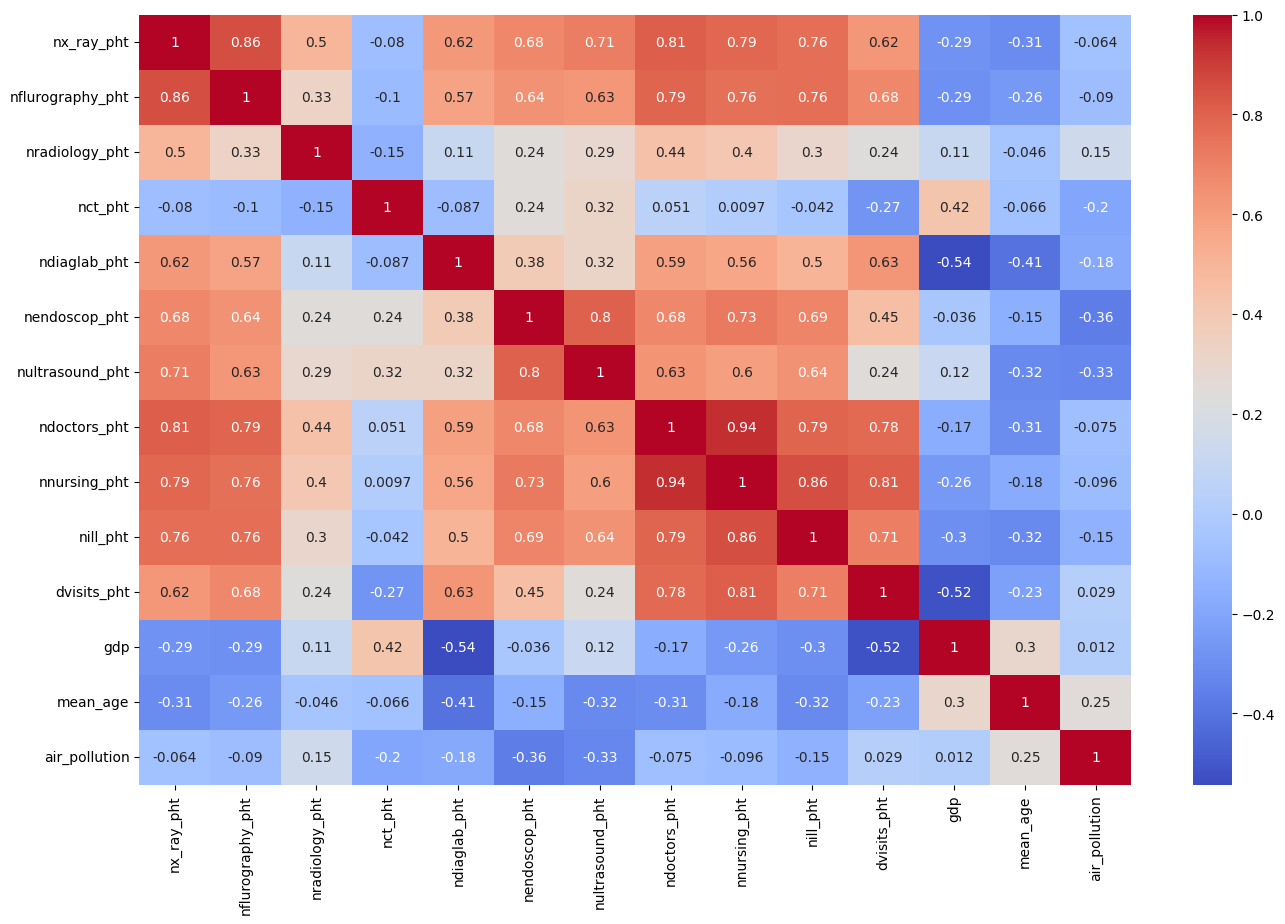

In [114]:
plt.figure(figsize=(16, 10))
correlation_matrix = st_df[all_explanatory_variables].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

As visible Equipment, personnel and illness variables posesses multicollinearity among themselves. This may be resolved in the following way. First, we create index for availability of equipment - **mdevindex**, which is equal to the average of ndiaglab_pht, nx_ray_pht, nultrasound_pht, nendoscop_pht, nultrasound_pht. nct_pht is left asside, first, because it is barely correlated with other columns, second, because we are particularlry interested in affect of effect of number of CT scans on mtumors_pti

In [115]:
st_df['mdevindex'] = (st_df['ndiaglab_pht'] + \
                     st_df['nx_ray_pht'] + \
                     st_df['nflurography_pht'] + \
                     st_df['nultrasound_pht'] + \
                     st_df['nendoscop_pht']) / 5

In [116]:
st_df['mdevindex'] /= st_df['ndoctors_pht'];
st_df['dvisits_pht'] /= st_df['ndoctors_pht'];

Then, we can get rid of **nnursing_pht** and **ndoctors_pht**, because it is highly correlated with other variables. And the effect of number of doctors is more interesting for analysis.

In [117]:
st_df = st_df.drop(columns=['nnursing_pht']);

As result, we get new set of variables

In [118]:
equipment_variables = [
    'nсt_pht', 'mdevindex'
]

personnel_variables = []

illness_variables = ['dvisits_pht']

environment_variables = ['air_pollution']

socioeconomic_variables = ["gdp", "mean_age"]

all_explanatory_variables = equipment_variables + personnel_variables + environment_variables + illness_variables + socioeconomic_variables

all_dependent_variables = ['mtumors_pti']

And uncorrelated set of expanatory variables:

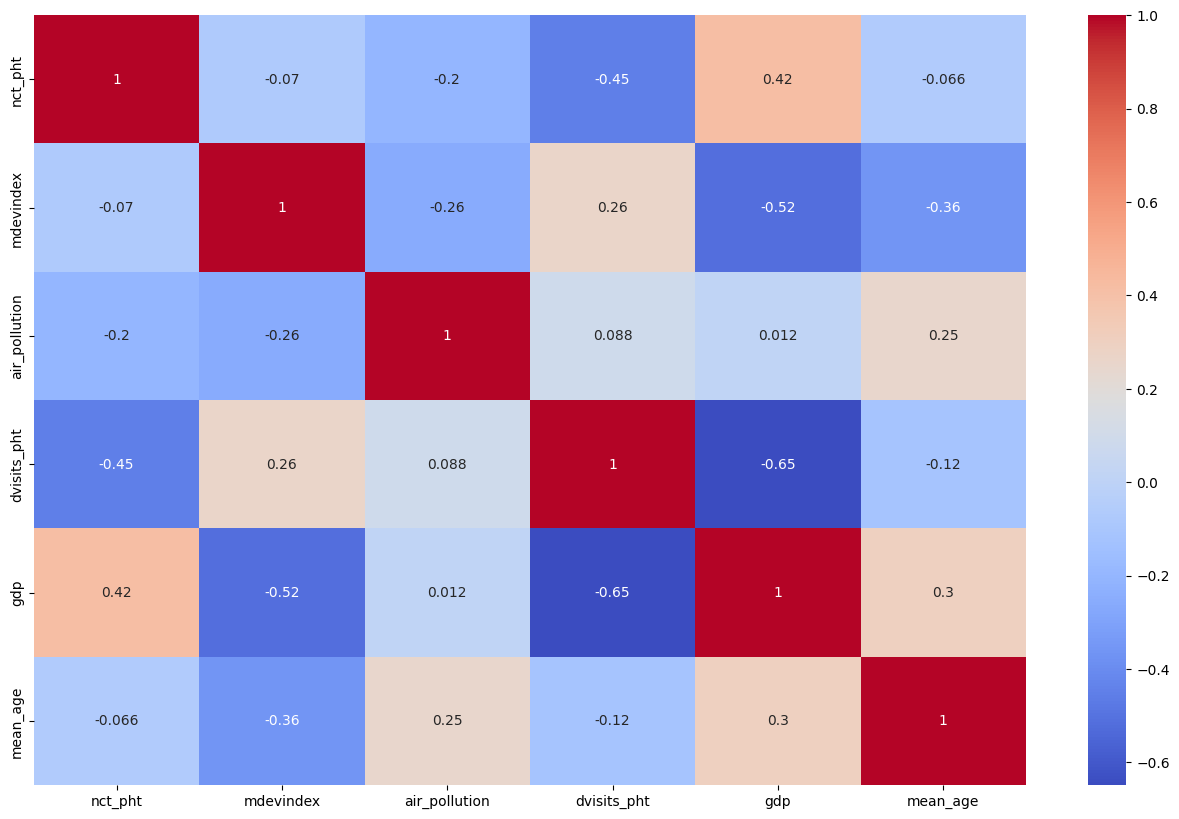

In [119]:
plt.figure(figsize=(16, 10))
correlation_matrix = st_df[all_explanatory_variables].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [120]:
mtumors_df = st_df[all_dependent_variables + all_explanatory_variables + ['region', 'year']]

### Trend account

First, we must get rid of "outlier" data: period of COVID19 and full-scale invasion, as well as daat from start of the war in Donetsk and Lukhansk regions

In [121]:
mtumors_df = mtumors_df[mtumors_df.year < 2020]
mtumors_df = mtumors_df[~mtumors_df.region.isin(['Донецька', 'Луганська'])]

Firstly, we can add number of years from start of observation as explanatory variable

In [122]:
mtumors_df['t'] = mtumors_df['year'] - 2008

Also in the years of observations medical system had undergone lots of reforms, which are really hard to model. To get rid of these effects, we focus analysis only on the differences between regions. 
Then for each year we can subtract the mean of each variable across all regions. This procedure is only done for equipment, medical personnel and illness variables 

In [123]:

def coupled_detrend(df: pd.DataFrame, x_names: list[str]):
    df = df.copy()
    years = sorted(df.year.unique())
    for x_name in x_names:
        for year in years:
            x_at_year = df[df.year == year][x_name]
            df.loc[df.year == year, x_name] = x_at_year - x_at_year.mean()
    
    return df


In [124]:
mtumors_df = coupled_detrend(mtumors_df, all_explanatory_variables) 

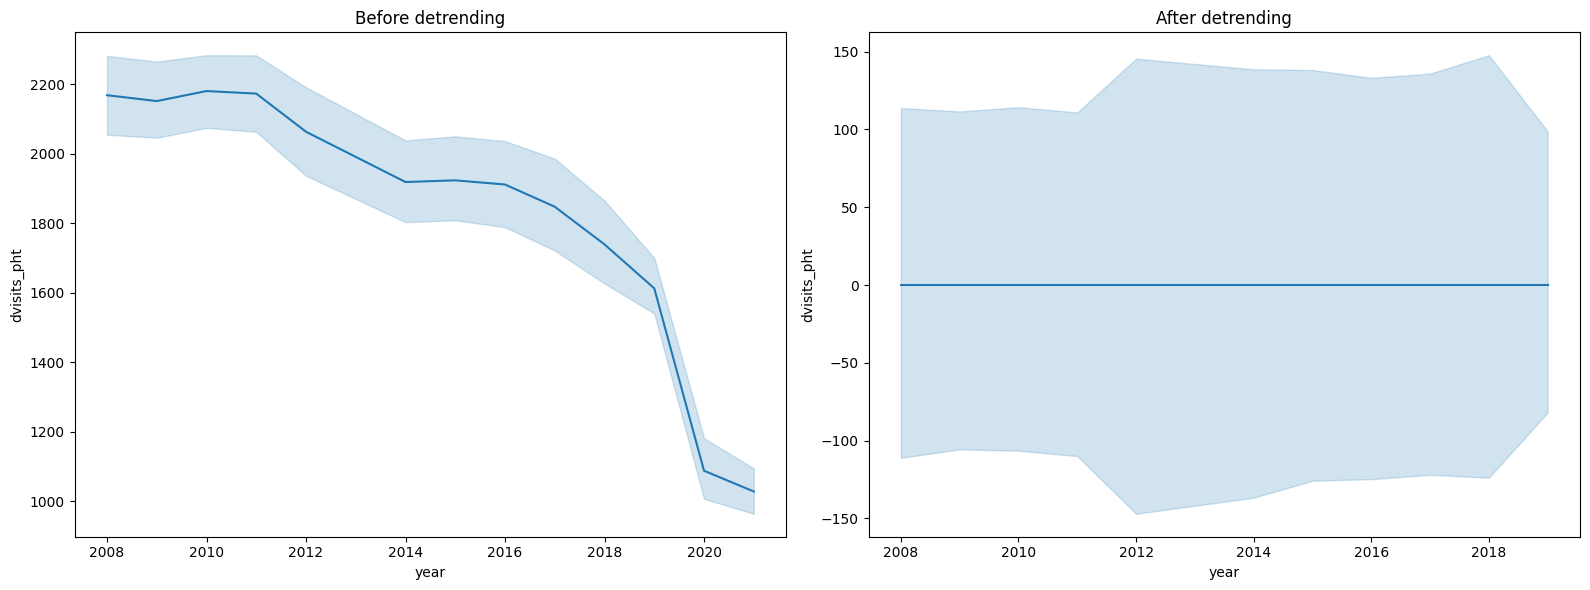

In [125]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(ax=axes[0], x=st_df.year, y=st_df.dvisits_pht)
axes[0].set_title("Before detrending")

sns.lineplot(ax=axes[1], x=mtumors_df.year, y=mtumors_df.dvisits_pht)
axes[1].set_title("After detrending")

plt.tight_layout()
plt.show()

## Model selection

In [126]:
all_explanatory_variables = equipment_variables + personnel_variables + illness_variables + socioeconomic_variables
explanatory = list(set(all_explanatory_variables + ['t']) - {'gdp'})

X = sm.add_constant(mtumors_df[explanatory])
y = np.log(mtumors_df['mtumors_pti'])
model = sm.OLS(y, X).fit(cov_type="HC1")

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            mtumors_pti   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     100.2
Date:                Wed, 30 Apr 2025   Prob (F-statistic):           2.15e-58
Time:                        20:34:54   Log-Likelihood:                 171.25
No. Observations:                 264   AIC:                            -330.5
Df Residuals:                     258   BIC:                            -309.0
Df Model:                           5                                         
Covariance Type:                  HC1                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.0488      0.013    302.942      0.000       4.023       4.075
nсt_pht        -0.2014      0.069     -2.904      0.004      -0.337      -0.065
mdevindex      -7.6133      3.201     -2.378      0.017     -13.887      -1.340
dvisits_pht     0.0002   2.98e-05      6.339      0.000       0.000       0.000
t               0.0263      0.002     13.902      0.000       0.023       0.030
mean_age        0.0525      0.004     13.240      0.000       0.045       0.060
==============================================================================
Omnibus:                        0.120   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.942   Jarque-Bera (JB):                0.251
Skew:                          -0.003   Prob(JB):                        0.882
Kurtosis:                       2.849   Cond. No.                     1.28e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 1.28e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""